<a href="https://colab.research.google.com/github/masterschool-content/retail_demand_forecast/blob/main/notebooks/XGBoost_demand_forecast_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up MLFlow

In [ ]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.0 MB/s eta 0:00:00


In [ ]:
import mlflow

## Connect storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir mlflow_results

In [ ]:
# To use MLFlow on Colab, we need to connect storage. We will use Google Drive

# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [ ]:
# Set up experiment name
mlflow.set_experiment("Demand Forecast Experiment")

<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_results/810397914936930866', creation_time=1730832689901, experiment_id='810397914936930866', last_update_time=1730832689901, lifecycle_stage='active', name='Demand Forecast Experiment', tags={}>

## Start MLFlow UI

In [ ]:
!pip install pyngrok --quiet

In [ ]:
from pyngrok import ngrok, conf
import getpass
import subprocess

In [ ]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel "https://a2af-34-168-235-166.ngrok-free.app" 


# Import all libraries we will need for the modeling and evaluation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import mlflow.pyfunc
import mlflow.models
from mlflow.models.signature import infer_signature
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb


# Read the files with pandas

In [ ]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

#Note: train file is very large.
#To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', nrows=6.5e7)
# Convert 'date' column to datetime in the train dataset
df_train['date'] = pd.to_datetime(df_train['date'])

<ipython-input-12-7e0168dd62ad>:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', nrows=2.5e7)


Hint: In the course we always load raw data and apply various transformation on it. To save time, you can create a notebook with data processing pipeline and store the output in final csv file. Later you simply read this preprocessed data in another notebook, where you work on the model. In this way you don't need to wait till data preprocessing is done every time you run the notebook to train the model and it will help you to ensure consistency if you train several models, without the need to copy-paste the code for data processing every time.

# Prepare data

## For the quick experimenting, we will select one store-product pair

In [ ]:
#store_id = [1]
#store_id = df_stores['store_nbr'].unique()
store_id = df_stores[df_stores['state']=='Pichincha']['store_nbr'].unique()
item_id = [564533,838216,582865,364606]
df_filtered = df_train[(df_train['store_nbr'].isin(store_id)) & (df_train['item_nbr'].isin(item_id))]

# Group by date and aggregate sales
df_filtered = df_filtered.groupby(['store_nbr','item_nbr','date']).sum()['unit_sales'].reset_index()

del df_train #clean-up memory, we don't need this dataframe

## Feature engineering

In [ ]:
data = df_filtered.copy() #we can easy switch between df_filtered and full dataset by assigning it to data variable

## Fill out missing dates with 0 sales

In [ ]:
import pandas as pd

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Create an empty DataFrame to store the final result
df_filled = pd.DataFrame()

# Iterate through each store and item combination
for (store, item), group in data.groupby(['store_nbr', 'item_nbr']):
    # Get the minimum and maximum dates in the dataset to create a full date range
    min_date = group['date'].min()
    max_date = group['date'].max()
    #print(min_date.date(), max_date.date())

    # Create a full date range covering all days between the min and max dates
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # Set 'date' as index and sort by date
    group.set_index('date', inplace=True)
    group = group.sort_index()

    # Reindex to fill missing dates with 0 sales
    group = group.reindex(full_date_range, fill_value=0)

    # Keep track of the store and item number for each row
    group['store_nbr'] = store
    group['item_nbr'] = item

    # Ensure that missing sales values are filled with 0
    group['unit_sales'] = group['unit_sales'].fillna(0)

    # Append the group to the final DataFrame
    df_filled = pd.concat([df_filled, group])

# Reset the index to get 'date' back as a column
df_filled.reset_index(inplace=True)
df_filled.rename(columns={'index': 'date'}, inplace=True)

2013-01-01 2014-06-07


In [ ]:
data = df_filled.copy()

## Add more time-based features

In [ ]:
#data.tail()

In [ ]:
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekofyear'] = data['date'].dt.isocalendar().week
data['dayofweek'] = data['date'].dt.dayofweek
data['rolling_mean'] = data['unit_sales'].rolling(window=7).mean()
data['rolling_std'] = data['unit_sales'].rolling(window=7).std()


# Create lag features (e.g., sales from the previous day, previous week)
data['lag_1'] = data['unit_sales'].shift(1)
data['lag_7'] = data['unit_sales'].shift(7)
data['lag_30'] = data['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
data.dropna(inplace=True)

# Add features related to stores and items

In [ ]:
# Merge df_filtered with df_store and df_item on store_nbr and item_nbr, respectively
data = data.merge(df_stores, on='store_nbr', how='left').merge(df_items, on='item_nbr', how='left')

from sklearn.preprocessing import LabelEncoder
# Apply label encoding to each categorical column
le = LabelEncoder()
for col in ['city', 'state', 'type', 'family', 'class']:
    data[col] = le.fit_transform(data[col])

#categorical_columns = ['city', 'state', 'type', 'family', 'class']
#for col in categorical_columns:
#    data[col] = data[col].astype('category')
data = data.sort_values(by=['store_nbr', 'item_nbr', 'date'])

In [ ]:
data.head(3)

,date,store_nbr,item_nbr,unit_sales,month,day,weekofyear,dayofweek,rolling_mean,rolling_std,lag_1,lag_7,lag_30,city,state,type,cluster,family,class,perishable
0,2013-01-31,1,364606,46.0,1,31,5,3,39.857143,12.954132,60.0,96.0,0.0,17,11,3,13,1,1,0
1,2013-02-01,1,364606,64.0,2,1,5,4,43.857143,15.614401,46.0,36.0,60.0,17,11,3,13,1,1,0
2,2013-02-02,1,364606,45.0,2,2,5,5,44.000000,15.620499,64.0,44.0,64.0,17,11,3,13,1,1,0


# Split in test and train datasets

In [ ]:
split_date = '2014-03-01'
train = data[data['date'] < split_date]
test = data[data['date'] >= split_date]
print("Train dataframe shape:",train.shape)
print("Test dataframe shape:",test.shape)

Train dataframe shape: (72050, 20)
Test dataframe shape: (16830, 20)


# ML model with XGBoost


In [ ]:
# Define target variable (unit_sales) and features
X_train = train.drop('unit_sales', axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop('unit_sales', axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

In [ ]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, enable_categorical=True)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

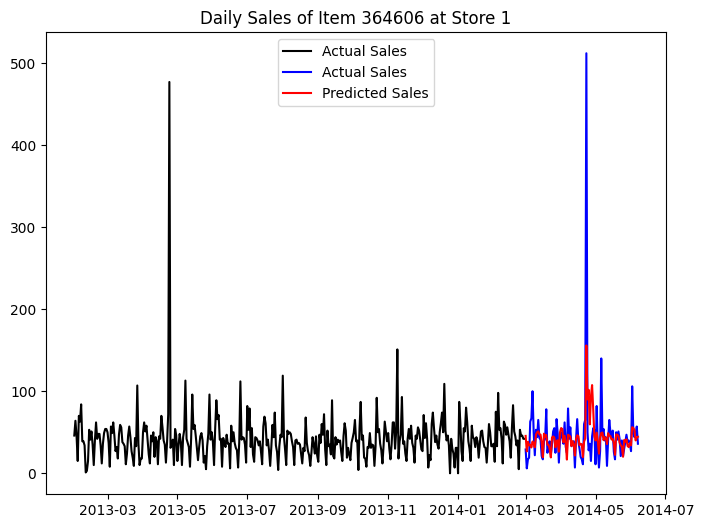

<Figure size 640x480 with 0 Axes>

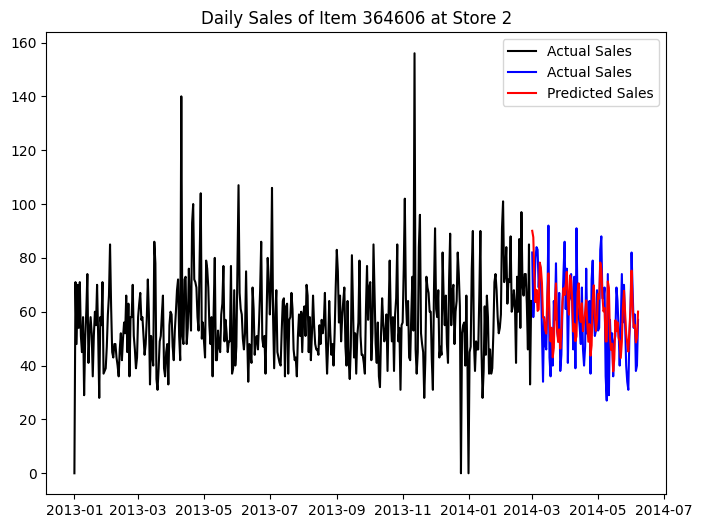

<Figure size 640x480 with 0 Axes>

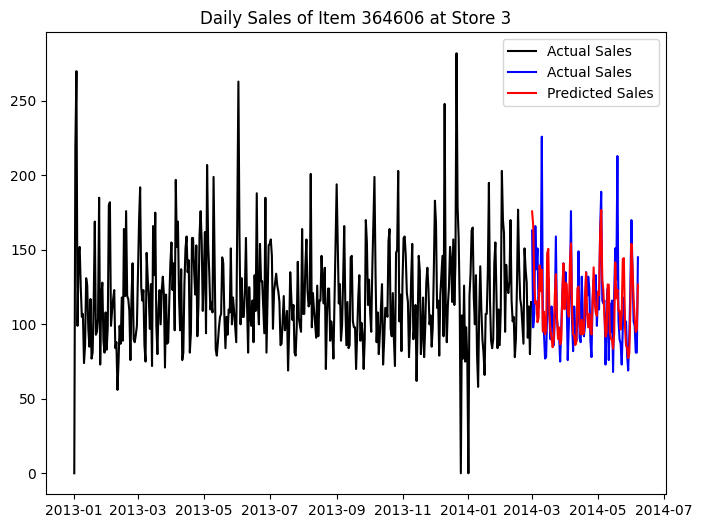

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate metrics values and Plot the actual vs predicted values
rmad_values = []
bias_values = []
rmse_values = []
plot_paths = []
plot_count  = 0
for (item_nbr, store_nbr), group in data.groupby(['item_nbr', 'store_nbr']):
  #group = group.groupby(['date']).sum()['unit_sales'].reset_index()
  test_series = group[group['date'] >= split_date]
  if(len(test_series)>10):
    X_test = test_series.drop('unit_sales', axis=1)
    X_test = X_test.drop('date', axis=1)
    y_test = test_series['unit_sales']
    # Make predictions on the test set
    y_pred = xgboost_model.predict(X_test)

    if plot_count<3:
      train_series = group[group['date'] < split_date]
      plt.figure(figsize=(8, 6))
      plt.plot(train_series['date'], train_series['unit_sales'].values, label='Actual Sales', color='black')
      plt.plot(test_series['date'], y_test.values, label='Actual Sales', color='blue')
      plt.plot(test_series['date'], y_pred, label='Predicted Sales', color='red')
      plt.title(f'Daily Sales of Item {item_nbr} at Store {store_nbr}')
      file_path = f'ARIMA_forecast_store_{store_id}_item_{item_nbr}.png'
      plt.legend()
      plt.show()
      plt.savefig(file_path)  # Saves the plot as a PNG file
      plot_paths.append(file_path)
      plot_count = plot_count + 1

    #Calculate metric values for XGBoost model
    # Bias calculation: mean of the residuals (y_pred - y_test)
    bias = np.mean(y_pred - y_test)
    bias_values.append(bias)
    # Root Mean Absolute Deviation (RMAD)
    rmad = np.mean(np.abs(y_pred - y_test))
    rmad_values.append(rmad)
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

## Log metrics for XGBoost model in MLFlow

In [ ]:
import mlflow.xgboost
with mlflow.start_run(run_name="XGBoost_store_item_features_run"):
    mlflow.log_param("objective", "reg:squarederror") #value we used above
    mlflow.log_param("n_estimators", 100) #value we used above
    mlflow.log_param("max_depth", 5) #value we used above
    mlflow.log_param("learning_rate", 0.1) #value we used above
    mlflow.log_metric("rMAD", sum(rmad_values)/len(rmad_values)) #average rMAD
    mlflow.log_metric("Bias", sum(bias_values)/len(bias_values)) #average Bias
    mlflow.log_metric("RMSE", sum(rmse_values)/len(rmse_values)) #average RMSE
    for plot_path in plot_paths:
      mlflow.log_artifact(plot_path, artifact_path="plots")
    # Log the XGBoost model
    ## Example data (replace with a sample from your dataset)
    #input_example = X_train[:5]
    # Infer signature from input and output data
    signature = infer_signature(X_train, xgboost_model.predict(X_train))
    #print(signature)
    #mlflow.sklearn.log_model(xgboost_model, "xgboost_model",
    #                         signature=signature)
    mlflow.xgboost.log_model(xgboost_model, "xgboost_model",
                             signature=signature)
    # Optionally log parameters, metrics, etc.
    mlflow.log_params(xgboost_model.get_params())
    mlflow.log_metric("train_score", xgboost_model.score(X_train, y_train))

/usr/local/lib/python3.10/dist-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:39:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose bet

inputs: 
  ['store_nbr': long (required), 'item_nbr': long (required), 'month': integer (required), 'day': integer (required), 'weekofyear': long (required), 'dayofweek': integer (required), 'rolling_mean': double (required), 'rolling_std': double (required), 'lag_1': double (required), 'lag_7': double (required), 'lag_30': double (required), 'city': long (required), 'state': long (required), 'type': long (required), 'cluster': long (required), 'family': long (required), 'class': long (required), 'perishable': long (required)]
outputs: 
  [Tensor('float32', (-1,))]
params: 
  None



# (Optional) save Pickle file with the model in Google Drive
Next week we will create an application with our model. To serve model in the application, we create a pickle file below and next week we will use this file in our app.
Note: you will experiment a lot and create many models. Pickle file you need only for the best model you create this week. To learn more about pickle files, please check the additional material suggested for this week.

In [ ]:
logged_model = 'runs:/288c9f141630411384c23e0a27a95d3f/xgboost_model' # you can find run id in MLFlow UI. See the video for more detailed instruction

# Load model as a generic PyFuncModel.
#loaded_model = mlflow.pyfunc.load_model(logged_model)
#input_schema = loaded_model.metadata.get_input_schema()
#print(input_schema)

# Load model as xgboost model
loaded_model = mlflow.xgboost.load_model(logged_model)
print("=== Model type",type(loaded_model))

=== Model type <class 'xgboost.sklearn.XGBRegressor'>


In [ ]:
# create the path to store pickle files of the models
!mkdir /content/drive/MyDrive/models/

mkdir: cannot create directory ‘/content/drive/MyDrive/models/’: File exists


In [ ]:
import pickle
# Save the model as a pickle file in Google Drive
pickle_path = '/content/drive/MyDrive/models/xgboost_model.pkl'  # Adjust Google Drive path as desired

with open(pickle_path, 'wb') as f:
    pickle.dump(loaded_model, f)

print(f"Model saved as pickle file at: {pickle_path}")

Model saved as pickle file at: /content/drive/MyDrive/models/xgboost_model.pkl


# Next steps
Now you can change the paramters of the model, fit the new model and compare the metrics in MLFlow. Also instead of manual tunning try Hyperparameter Tuning, does it give you better result then the default parameters?